## **1. Introduction**

The objective of this laboratory is to implement a model for image captioning task. From an input image, we want to generate a text describing the image.

Dataset can be downloaded from masterVAR and should be uploaded to your gdrive to be used in colab. 

The laboratory is split up as follows:

*   Introduction (set-up and dataset description)
*   Data processing and loading
*   Model definition
*   Training & inference
*   Assignment

The dataset we will use today is called Flickr8k. It's a small dataset composed of 8091 images and five captions for each images. 

We will use PyTorch during the lab.

In [1]:
# Import block

# Generic librairies
import os
import numpy as np
import glob

# Torch
import torch
from torch.utils.data import DataLoader,Dataset,random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim

# Torchvision
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# Captions management
import pandas
import spacy
from collections import Counter

# Image display
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Switch to Execution type CPU -> GPU in colab before launching this cell
# If the result is 'cpu', you're on the cpu if the result is cuda:0, you're on the gpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Link google drive to Colab and access your files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Unzip images

!unzip '/content/drive/MyDrive/Flicker8k_images.zip' -d '/content/drive/MyDrive/'

unzip:  cannot find or open /content/drive/MyDrive/Flicker8k_images.zip, /content/drive/MyDrive/Flicker8k_images.zip.zip or /content/drive/MyDrive/Flicker8k_images.zip.ZIP.


In [6]:
# Unzip labels file

!unzip '/content/drive/MyDrive/Flickr8k_labels.zip' -d '/content/drive/MyDrive/'

unzip:  cannot find or open /content/drive/MyDrive/Flickr8k_labels.zip, /content/drive/MyDrive/Flickr8k_labels.zip.zip or /content/drive/MyDrive/Flickr8k_labels.zip.ZIP.


In [4]:
# Define data paths

imagesFolder = '/content/drive/MyDrive/Flicker8k_images/'
captionsFile = '/content/drive/MyDrive/Flickr8k_labels.txt'

In [5]:
# Grouping images thanks to glob and print the number of images

imagePaths = list(glob.glob(imagesFolder+"*.jpg"))

# Sort the list
imagePaths.sort()

# Check the number of images in the list (it should be 8091 images)
print("number of images:",len(imagePaths))


number of images: 8091


In [6]:
# Dataframe

# Open the labels file and create a dataframe with first column 'images', and second column 'captions'. The number of captions should be 8091*5 = 40455
# Check pandas.read_csv() function
labelFile = pandas.read_csv(captionsFile, sep=',')
pandas.set_option('display.max_colwidth', None)

# Display the first 10 rows of the dataframe

print("number of captions:",len(labelFile))
labelFile.head(10)


number of captions: 40455


,images,captions
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other


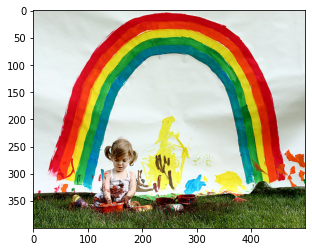

image name : 1002674143_1b742ab4b8.jpg 

       A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl
                                     A little girl is sitting in front of a large painted rainbow
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it
                             There is a girl with pigtails sitting in front of a rainbow painting
                                           Young girl with pigtails painting outside in the grass


In [7]:
# Define the function displayFile. The function display an image and its corresponding captions based on the index of the previous dataframe.

def displayFile(index):
  # Dataframe.loc access a group of rows and columns by label(s) or a boolean array.
  imageName = labelFile.loc[index]['images']
  image = Image.open(imagesFolder+imageName)
  plt.imshow(image)
  plt.show()
  print("image name :", imageName,"\n")
  captions = labelFile[labelFile['images']== imageName]['captions']
  print(captions.to_string(index=False))

# Max index is 40454 -> 8091 (images) * 5 (captions) starting at 0
displayFile(10)


# Browse images of the flickr8k dataset thanks to the displayFile function

## **2. Data processing and loading**

Data processing and loading steps have two goals:
* The first one is to apply some kind of preprocessing on images and captions so that our model can later take them as inputs
* The second one is to create a dataloader object providing to the model batch of data

In PyTorch, we can define custom class for everything: class for a model, for a dataset, for a dataloader.

In [8]:
# Tokenizer
# The goal of the tokenizer is to turn captions into sequences of word tokens
# Use spacy and try to tokenize one of the caption contained in the dataframe

spacyEnglish = spacy.load("en_core_web_sm")
captionExample = "A girl going into a wooden building"
[token.text.lower() for token in spacyEnglish.tokenizer(captionExample)]



['a', 'girl', 'going', 'into', 'a', 'wooden', 'building']

In [9]:
# Vocabulary definition

# Create a vocabulary class. The class will maps each tokens to one integer.
# Define the intToString mapping so that : 0 = <PAD>, 1 = "<START>" , 2 = <STOP> and 3 = "<UNK>"
# Define the reverse mapping

class myVocabulary:
    def __init__(self,frequencyThreshold):
        
        #setting the pre-reserved tokens int to string tokens
        self.intToString = {0:"<PAD>",1:"<START>",2:"<STOP>",3:"<UNK>"}

        self.stringToInt = {value:key for key,value in self.intToString.items()}
        
        self.frequencyThreshold = frequencyThreshold
        
    def __len__(self): 
      return len(self.intToString)
    
    # Static methods in Python are extremely similar to python class level methods, the difference being that a static method is bound to a class rather than the objects for that class.
    # This means that a static method can be called without an object for that class. This also means that static methods cannot modify the state of an object as they are not bound to it. 
    @staticmethod
    def tokenizer(caption):
        return [token.text.lower() for token in spacyEnglish.tokenizer(caption)]
    

    def buildVocabulary(self, captionList):
        frequencies = Counter()
        # starting index
        index = 4
        
        for caption in captionList:
            for word in self.tokenizer(caption):
                #print(word)
                frequencies[word] += 1  
                #print(frequencies[word])
                # add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.frequencyThreshold:
                    self.stringToInt[word] = index
                    self.intToString[index] = word
                    index += 1
    
    def numericalize(self,caption):
        tokenizedCaption = self.tokenizer(caption)
        return [ self.stringToInt[token] if token in self.stringToInt else self.stringToInt["<UNK>"] for token in tokenizedCaption ]   

In [10]:
# Define a vocabulary. Test buildVocabulary and numericalize on one caption. Print stringToIntMapping

vocabulary = myVocabulary(frequencyThreshold=1)

vocabulary.buildVocabulary(["A girl going into a wooden building"])
print(vocabulary.stringToInt)
print(vocabulary.intToString)
print(vocabulary.numericalize("A girl going into a wooden building"))

{'<PAD>': 0, '<START>': 1, '<STOP>': 2, '<UNK>': 3, 'a': 4, 'girl': 5, 'going': 6, 'into': 7, 'wooden': 8, 'building': 9}
{0: '<PAD>', 1: '<START>', 2: '<STOP>', 3: '<UNK>', 4: 'a', 5: 'girl', 6: 'going', 7: 'into', 8: 'wooden', 9: 'building'}
[4, 5, 6, 7, 4, 8, 9]


In [11]:
# Dataset 

# There are several datasets class included in PyTorch for famous datasets. Some of the class got a download option which is very convenient.
# In this previous case, a call to the dataset class of imagenet for instance, enable us to download the dataset, store images and labels into tensors.
# These tensors will be fed into neural network.

# With flickr8k, it's not possible to download the dataset, so we will define a custom dataset class to process it.
# The goal of flickr8k class it to get images and corresponding captions and store them into tensors.

# We will initialize the vocabulary in the dataset class

class flickr8kDataset(Dataset):

  def __init__(self,imagesFolder,captionsFile,transform=None,frequencyThreshold=5):

    # Initialize parameters of __init__

    # Retrieve images paths and corresponding labels thanks to pandas and store them into a dataframe
    self.imagesFolder = imagesFolder
    self.labelFile = pandas.read_csv(captionsFile, sep=',')
    self.transform = transform

    # Initialize and generate the vocabulary from captions list
    self.images = self.labelFile["images"]
    self.captions = self.labelFile["captions"]

    self.vocabulary = myVocabulary(frequencyThreshold)
    self.vocabulary.buildVocabulary(self.captions.tolist())
  
  def __len__(self):
    # return the size of the dataset
    return len(self.labelFile)
  
  def __getitem__(self,index):

    # Caption pre-processing
    caption = self.captions[index]
    tokenizedCaption = []

    # Add <START> and <STOP> tokens at the beggining and end of each captions.
    # Turn the caption into integer tokens
    tokenizedCaption += [self.vocabulary.stringToInt["<START>"]]
    tokenizedCaption += self.vocabulary.numericalize(caption)
    tokenizedCaption += [self.vocabulary.stringToInt["<STOP>"]]
    
    # Image pre-processing

    # Open the image and convert it to RGB
    imageName = self.images[index]
    imagePath = os.path.join(self.imagesFolder,imageName)
    image = Image.open(imagePath).convert("RGB")

    # Apply transform operation on image
    if self.transform is not None:
      image = self.transform(image)

    # return pre-processed image and caption as tensors
    return image, torch.tensor(tokenizedCaption)

In [12]:
# Image processing try

# Define a transform operation for the images of the dataset. Check transforms.Compose()

# Resize images to (224,224)
# Convert images into tensor
transformsTest = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()                              
])

In [13]:

# Try to define a dataset
myDataset =  flickr8kDataset(imagesFolder = imagesFolder, captionsFile = captionsFile,transform=transformsTest)

In [14]:
# Define a function displaying: image, tokenized caption, and numericalized caption from previous dataset

def displayDataset(index):
  image, caption = myDataset[index]
  
  # done to reverse the operation done by toTensor : HWC
  image = image.numpy().transpose((1,2,0))
  plt.imshow(image)
  plt.show()

  print("Tokenized caption:",[myDataset.vocabulary.intToString[token] for token in caption.tolist()])
  print("Tokens to int:", caption)

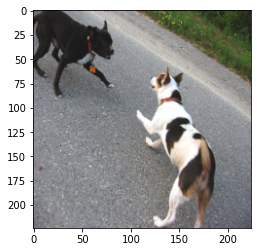

Tokenized caption: ['<START>', 'a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<STOP>']
Tokens to int: tensor([  1,   4,  19,   5,  15,   4, 678,   5,  33, 692,   2])


In [15]:
displayDataset(5)

In [16]:
# Padding and Collate

# Captions can have different sizes. To ease captions processing, we padd the captions so that all captions have the same lenght inside a same batch of data.
# Collate is used by data loader. After defining a dataset, we can use a data loader loading the data and providing an iterator to process dataset as batch (X,Y)

class paddingAndCollate:

  def __init__(self,paddingIndex,batchFirst=False):
    
    # initialize parameters
    self.paddingIndex = paddingIndex
    # Output will be in B x T x * if True, or in T x B x * otherwise. Default: False.
    self.batchFirst = batchFirst
  
  def __call__(self,batch):

    # Apply padding to captions in the batch. Check pad_sequence()
    images = [item[0].unsqueeze(0) for item in batch]

    # Concatenation
    images = torch.cat (images,dim=0)

    # Collate images of the batch so they can be used by the dataloader.
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first = self.batchFirst, padding_value = paddingIndex)
    return images,targets

In [17]:
# Dataloader and iterator

# Constant needs for dataloader
BATCH_SIZE_TEST = 4
NUM_WORKER_TEST = 1

# Which int is representing the <PAD> token
paddingIndex = myDataset.vocabulary.stringToInt["<PAD>"]

# Try to define a dataloader with previous dataset, and collate_fn parameter defined thanks to paddingAndCollate class
dataloaderTest = DataLoader(dataset=myDataset,batch_size=BATCH_SIZE_TEST,num_workers=NUM_WORKER_TEST,shuffle=True,collate_fn=paddingAndCollate(paddingIndex=paddingIndex,batchFirst=True))

In [18]:
# Define a function displaying a batch

def displayBatch(batch):
  images, captions = batch
  for i in range(BATCH_SIZE_TEST):
    image,caption = images[i],captions[i]
    image = image.numpy().transpose((1,2,0))
    plt.imshow(image)
    plt.show()
    print("Tokenized caption:",[myDataset.vocabulary.intToString[token] for token in caption.tolist()])
    print("Caption feed in inputs:", caption)

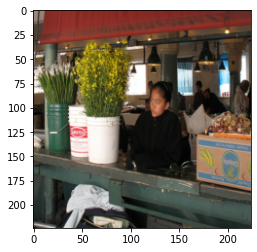

Tokenized caption: ['<START>', 'a', 'woman', 'dressed', 'in', 'black', 'standing', 'at', 'a', 'green', 'counter', 'with', '<UNK>', 'of', 'flowers', 'placed', 'on', 'it', '<STOP>']
Caption feed in inputs: tensor([   1,    4,   78,  214,    7,   19,   67,   18,    4,   56, 1397,   11,
           3,   10,  378, 1406,   12,   62,    2])


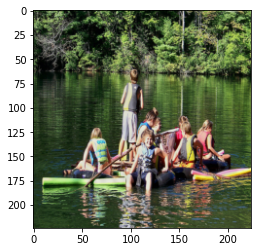

Tokenized caption: ['<START>', 'a', 'group', 'of', 'kids', 'float', 'in', 'the', 'middle', 'of', 'a', 'pond', '<STOP>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Caption feed in inputs: tensor([  1,   4,  91,  10, 256, 956,   7,   9, 371,  10,   4, 471,   2,   0,
          0,   0,   0,   0,   0])


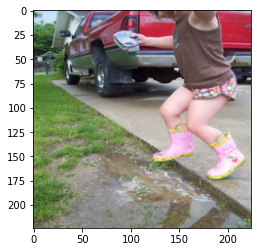

Tokenized caption: ['<START>', 'a', 'little', 'girl', 'is', 'about', 'to', 'jump', 'into', 'a', 'mud', 'puddle', 'with', 'her', 'flower', 'rain', 'boots', '<STOP>', '<PAD>']
Caption feed in inputs: tensor([  1,   4,   8,   6,  16, 296,  26, 497,  74,   4, 634, 824,  11, 102,
        574, 925, 496,   2,   0])


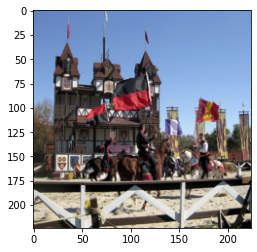

Tokenized caption: ['<START>', 'several', '<UNK>', 'are', 'riding', 'past', 'each', 'other', 'carrying', 'flags', '<STOP>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Caption feed in inputs: tensor([  1, 137,   3,  33, 166, 464, 104, 105, 204, 679,   2,   0,   0,   0,
          0,   0,   0,   0,   0])


In [19]:
# Define an iterator from dataloader
dataIteratorTest = iter(dataloaderTest)

# Get the next batch and display it
batch = next(dataIteratorTest)
displayBatch(batch)

# Try to do this several time to understand how data are fed to the model

In [20]:
# Example of image processing for resNet

# We will use ResNet as encoder. We need to do some changes on inputs images to feed them to ResNet.

# Apply a transform which resize the height of the image to 256. Add a randomCrop(224). Apply normalization (use mean and std of imageNet). Don't forget, the result must be a tensor

transforms = transforms.Compose([
    transforms.Resize(256),
    # Random crop is a data augmentation technique wherein we create a random subset of an original image. 
    # This helps our model generalize better because the object(s) of interest we want our models to learn are not always wholly visible in the image or the same scale in our training data.                     
    transforms.RandomCrop(224),                 
    transforms.ToTensor(),                               
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [21]:
# Define a dataset with the new transforms

dataset =  flickr8kDataset(imagesFolder = imagesFolder, captionsFile = captionsFile,transform=transforms)

In [22]:
# Split previous dataset on train, validation and test dataset (train : 0.7, val : 0.2, test : 0.1)

def splitDataset(dataset):

  # Check random_split

  size = len(dataset)
  
  trainSize = int(0.7 * size)
  valSize = int(0.2 * size)
  testSize = size - (trainSize + valSize)

  trainDataset, valDataset, testDataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

  return trainDataset, valDataset, testDataset

In [23]:
# Split the dataset and check the size and content of the different dataset
trainDataset, valDataset, testDataset = splitDataset(dataset)

print(len(trainDataset))
print(len(valDataset))
print(len(testDataset))


28318
8091
4046


In [24]:
# Set-up constants used for dataloader, model and training

# For dataloader
BATCH_SIZE = 512
NUM_WORKER = 2

# Model and training
layersNumber = 2
embeddingSize = 400
hiddenSize = 512
learningRate = 0.001
epochNumber = 2

vocabularySize = len(dataset.vocabulary)
print(vocabularySize)

print(dataset.vocabulary.intToString[13])
print(dataset.vocabulary.stringToInt["man"])

2991
man
13


In [65]:
# Define dataloader for train, val and test datasets
trainDataloader = DataLoader(dataset=trainDataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKER,shuffle=True,collate_fn=paddingAndCollate(paddingIndex=paddingIndex,batchFirst=True))
valDataloader = DataLoader(dataset=valDataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKER,shuffle=True,collate_fn=paddingAndCollate(paddingIndex=paddingIndex,batchFirst=True))
testDataloader = DataLoader(dataset=testDataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKER,shuffle=True,collate_fn=paddingAndCollate(paddingIndex=paddingIndex,batchFirst=True))

## **3. Model definition**

Now, we will implement the neural network model to process previous inputs.
As a reminder from the lecture, image captioning is a sequence to sequence problem (sequence of pixels into sequence of words). Therefore, our network must be composed of an encoder and a decoder.

The encoder process the input sequence (here an image) and extract features from it. These features will be passed to the decoder to produce the output sequence.

The encoder take inputs=[images] and outputs=[images features]

In our case, choose a CNN as encoder is a good choice to describe the image. To avoid re-training a CNN from scratch, we will use a pre-trained CNN on ImageNet.
CNN's architecture can vary, we will use Resnet architecture.

For the decoder, we will use a LSTM, but GRU or Transformer could also be used. We don't use vanilla RNNs which are hard to use in practice due to vanishing gradient problem.

At a given timestep, decoder takes as inputs=[images features , current word] and outputs=[next predicted words]

In [25]:
from torchvision.models.resnet import ResNet50_Weights
# Encoder - CNN ResNet - Pre-trained

class EncoderCNN(nn.Module):

  # Initialization for transfer learning with ResNet50
  def __init__(self, embeddingSize):
    
    # Super init
    super().__init__()
    # Use ResNet50 pretrained
    model = torchvision.models.resnet50(pretrained=True)
    # Because Resnet is already trained, we need to deactivate the gradient for the encoder
    for parm in model.parameters():
      parm.requires_grad_(False)
    # Delete the last layer of ResNet
    new = list(model.children())[:-1]
    # Create a linear layer to connect with decoder
    self.model = nn.Sequential(*new)
    self.embed = nn.Linear(model.fc.in_features, embeddingSize)
  # Compute the forward pass from the image
  def forward(self, images):
    # Pass into ResNet
    imagesFeatures = self.model(images)
    # Pass into the linear layer
    imagesFeatures = imagesFeatures.view(imagesFeatures.size(0), -1)
    imagesFeatures = self.embed(imagesFeatures)
    return imagesFeatures

In [26]:
from torch.nn.modules import dropout
# Decoder - LSTM

class DecoderRNN(nn.Module):

  def __init__(self,embeddingSize, hiddenSize, vocabularySize, layersNumber=1,pDropout=0.3):
    
    # Super init
    super().__init__()
    # Define embedding layer
    self.embeddingSize = embeddingSize
    # Define LSTM layer
    self.hiddenSize = hiddenSize
    # Define linear layer
    self.vocabularySize = vocabularySize
    self.layersNumber = layersNumber
    self.word_embedding = nn.Embedding(self.vocabularySize, self.embeddingSize)
    # Define dropout
    self.pDropout = pDropout
    self.lstm = nn.LSTM(input_size = self.embeddingSize,
                        hidden_size = self.hiddenSize,
                        num_layers = self.layersNumber,
                        dropout = self.pDropout,
                        batch_first=True)
    
    self.fc = nn.Linear(self.hiddenSize, self.vocabularySize)

  def init_hidden( self, BATCH_SIZE ):
    return ( torch.zeros( self.layersNumber , BATCH_SIZE , self.hiddenSize  ).to(device),
            torch.zeros( self.layersNumber , BATCH_SIZE , self.hiddenSize  ).to(device) )
  # Forwad pass
  def forward(self, features, captions):
    # Vectorization of the caption
    captions = captions[:,:-1]
    self.batch_size = features.shape[0]
    self.hidden = self.init_hidden( self.batch_size )
    embeds = self.word_embedding(captions)
    # Concatenate images features and captions
    inputs = torch.cat((features.unsqueeze(dim=1),embeds),dim=1)
    # Do the forward pass on concatenated inputs
    lstm_out , self.hidden = self.lstm(inputs,self.hidden)
    outputs = self.fc(lstm_out)
    return outputs

  # Inference function used to predict a caption from an image and previous words in the caption
  def captionGeneration(self,inputs,hidden=None,lenght=20,vocabulary=None):

    prediction = []
    predictions = []
    batch_size = inputs.shape[0]
    #inputs = inputs.unsqueeze(0)
    hidden = self.init_hidden(batch_size) 
    # For a maximal length of the caption
    while True:
      # Compute pass through lstm + linear
      lstm_out, hidden = self.lstm(inputs,hidden)
      outputs = self.fc(lstm_out)
      outputs = outputs.squeeze(1)
      # Select the output with the greater value
      _, max_idx = torch.max(outputs, dim=1)
      # Save the word into the result
      prediction.append(max_idx.cpu().numpy()[0])
      # Check if this input is <STOP>, if not continue
      if (len(prediction)>=20 or max_idx ==2):
        break
      # Use predicted word as input for the next timestep
      inputs = self.word_embedding(max_idx)
      inputs = inputs.unsqueeze(1)
    # Transform the predicted caption into string
    for token in prediction:
      predictions.append(dataset.vocabulary.intToString[token])
    return predictions

In [27]:
# Encoder-Decoder

class encoderDecoder(nn.Module):

  def __init__(self,embeddingSize, hiddenSize, vocabularySize, layersNumber=1,pDropout=0.3):

    # Super init
    super().__init__()
    # Encoder
    self.encoder = EncoderCNN(embeddingSize)
    # Decoder
    self.decoder = DecoderRNN(embeddingSize,hiddenSize,vocabularySize,layersNumber,pDropout=0.3)
  def forward(self, images, captions):
    # Encoder
    self.encoder.to(device)
    images = images.to(device)
    imagesFeatures = self.encoder.forward(images)
    # Decoder
    self.decoder.to(device)
    output = self.decoder.forward(imagesFeatures,captions)
    #outputs = self.decoder.captionGeneration(output,hiddenSize,lenght=20,vocabulary=dataset.vocabulary)
    
    return output

In [28]:
# Define model, loss function and optimizer

model = encoderDecoder(embeddingSize,hiddenSize,vocabularySize,layersNumber,pDropout=0.3)
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( params  = model.parameters() , lr =learningRate)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## **4. Training & inference**

Training jobs phase and inference

In [34]:
# Unnormalize images for display
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)
# Class doing the reverse normalization

class UnNormalize(object):

  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  # Take tensor image of size (channel, height, width), do reverse normalization and returns image to be display
  def __call__(self, tensor):
     # The normalize code is t.sub_(m).div_(s). Here we do reverse operations.
      for t, m, s in zip(tensor, self.mean, self.std):
        t.mul_(s).add_(m)
        return tensor

# Define a function taking as input an image tensor, a caption. The function do reverse normalization and then display image and caption as title from image Tensor
def ReverseAndDisplay(image,caption):
  # Define the reverse normalization operation and apply it
  unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  image = unorm(image)
  # Transpose from tensor to displayable image
  image = image.cpu().numpy().transpose((1,2,0))
  plt.imshow(image)
  plt.show()
  # Display caption if exist
  print("Caption :", caption)
   # Pause for the display

In [47]:
# Simple training procedure example. For each epoch, the loss, predicted caption and image are displayed.
import math
BATCH_SIZE = 1
NUM_WORKER = 2
# Model and training
layersNumber = 2
embeddingSize = 400
hiddenSize = 512
learningRate = 0.0001
epochNumber = 2
vocabularySize = len(dataset.vocabulary)
steps = math.ceil(len(trainDataset)/BATCH_SIZE)
print(steps)


model.train()
for epoch in range(epochNumber):
  for step in range(steps):
    images, captions = next(iter(trainDataloader))
    images , captions = images.to(device) , captions.to(device)
    optimizer.zero_grad()
    output = model.forward(images,captions)
    loss = criterion( output.view(-1, vocabularySize) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( epoch+1,epochNumber,step,steps,loss.item() )
    print(stat_vals)
    pred = model.encoder(images).unsqueeze(1)
    if step % 50 == 0:
      PredOutput = model.decoder.captionGeneration(inputs=pred,hidden=hiddenSize,lenght=20,vocabulary=dataset.vocabulary)
      ReverseAndDisplay(images[0],PredOutput)

  
  



28318


KeyboardInterrupt: ignored

In [38]:
# Validation loss callback

class Callback_computeValidationMetrics():
  def __init__(self, validationDataloader, criterion, device, vocab_size):
    self.validationDataloader = validationDataloader
    self.criterion = criterion
    self.vocab_size = vocab_size
    self.device = device
  def __call__(self, model):
    loss = 0
    # Switch to eval norm (deactive batchnorm & dropout layers)
    model.eval()
    # return validationLoss for each batch and compute averagedValidationLoss with values for every batch
    for i in range(math.ceil(len(valDataset)/BATCH_SIZE)):
      #print(i)
      # Load batch to device and compute outputs
      images, captions = next(iter(self.validationDataloader))
      images , captions = images.to(device) , captions.to(device)
      output = model.forward(images,captions)
      # Compute loss
      loss = loss+ self.criterion(output.view(-1, self.vocab_size) , captions.view(-1)).item()
      #print(loss)
    # Compute average loss
    avg_loss = loss/math.ceil(len(valDataset)/BATCH_SIZE)
    return avg_loss
# Callback call

In [ ]:
# Do training procedure
import math
# Parameters
BATCH_SIZE = 512
NUM_WORKER = 2
# Model and training
layersNumber = 2
embeddingSize = 400
hiddenSize = 512
learningRate = 0.001
epochNumber = 20
vocabularySize = len(dataset.vocabulary)
steps = math.ceil(len(trainDataset)/BATCH_SIZE)
#print(steps)
T_loss = []
V_loss = []

# Until the number of epochs is not reach:
for epoch in range(epochNumber):
  train_Loss=0
  val_Loss=0
  # Train the model
  # Loop on batch
  for step in range(steps):
    # Prepare data
    model.train()
    images, captions = next(iter(trainDataloader))
    images , captions = images.to(device) , captions.to(device)
    optimizer.zero_grad()
    output = model.forward(images,captions)
    loss = criterion(output.view(-1, vocabularySize) , captions.view(-1))
    #callback = Callback_computeValidationMetrics(valDataloader,criterion,device,vocabularySize)
    #val_loss = callback(model)
    train_Loss = train_Loss + loss.item()
    #val_Loss = val_Loss + val_loss
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Steps [%d/%d] Train_Loss[%.4f] ' %( epoch+1,epochNumber,step+1,steps,loss.item() )
    print(stat_vals)
  # Compute Train and Validation losses for the batch
  avg_trainloss = train_Loss / steps
  #avg_valloss = val_Loss / steps
  avg_vals = 'Epochs [%d/%d] Train_Loss[%.4f] ' %( epoch+1,epochNumber,avg_trainloss)
  print(avg_vals)
  # Training graph
  T_loss.append(avg_trainloss)
  #V_loss.append(avg_valloss)
  # Save model weights
  torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/image_captioning_model/', 'model_train_epoch{}.pkl'.format(epoch+1)))


Epochs [1/20] Steps [1/56] Train_Loss[8.0044] 
Epochs [1/20] Steps [2/56] Train_Loss[7.3895] 
Epochs [1/20] Steps [3/56] Train_Loss[6.5834] 
Epochs [1/20] Steps [4/56] Train_Loss[4.7585] 
Epochs [1/20] Steps [5/56] Train_Loss[4.1709] 
Epochs [1/20] Steps [6/56] Train_Loss[4.5262] 
Epochs [1/20] Steps [7/56] Train_Loss[3.5836] 
Epochs [1/20] Steps [8/56] Train_Loss[3.9132] 
Epochs [1/20] Steps [9/56] Train_Loss[3.8453] 
Epochs [1/20] Steps [10/56] Train_Loss[2.5672] 
Epochs [1/20] Steps [11/56] Train_Loss[2.7317] 
Epochs [1/20] Steps [12/56] Train_Loss[3.0019] 
Epochs [1/20] Steps [13/56] Train_Loss[3.1924] 
Epochs [1/20] Steps [14/56] Train_Loss[2.5157] 
Epochs [1/20] Steps [15/56] Train_Loss[2.9475] 
Epochs [1/20] Steps [16/56] Train_Loss[2.4104] 
Epochs [1/20] Steps [17/56] Train_Loss[2.6570] 
Epochs [1/20] Steps [18/56] Train_Loss[2.3004] 
Epochs [1/20] Steps [19/56] Train_Loss[2.7211] 
Epochs [1/20] Steps [20/56] Train_Loss[1.9857] 
Epochs [1/20] Steps [21/56] Train_Loss[2.6035] 
E

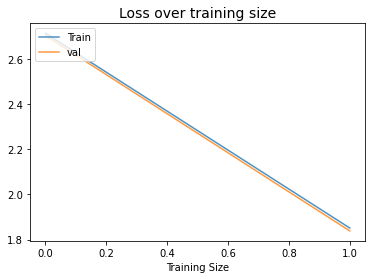

In [40]:
#plot training graph
from matplotlib import pyplot as plt
plt.plot(T_loss, alpha=0.8, label='Train')
plt.plot(V_loss,  alpha=0.8, label='val')
plt.title("Loss over training size", fontsize=14)
plt.xlabel('Training Size')
plt.legend(loc='upper left')
plt.show()

In [29]:
BATCH_SIZE = 1

testDataloader = DataLoader(dataset=testDataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKER,shuffle=True,collate_fn=paddingAndCollate(paddingIndex=paddingIndex,batchFirst=True))

In [30]:
# Inference
def inference(model,iterator,vocabulary) :

   # Switch to eval
    model.eval()
    # Get next image and caption thanks to the iterator
    for i in range(math.ceil(len(testDataset)/BATCH_SIZE)):
      images, captions = next(iter(iterator))
      images , captions = images.to(device) , captions.to(device)
      output = model.forward(images,captions)
      pred = model.encoder(images).unsqueeze(1)
      PredOutput = model.decoder.captionGeneration(inputs=pred,hidden=hiddenSize,lenght=20,vocabulary=dataset.vocabulary)
      print("True caption: ",captions)
      ReverseAndDisplay(images[0],PredOutput)

In [31]:
# Load best weights for inference
modelInference = encoderDecoder(embeddingSize,hiddenSize,vocabularySize,layersNumber,pDropout=0.3)
modelInference.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/image_captioning_model/', 'model_train_epoch{}.pkl'.format(11))))

<All keys matched successfully>

True caption:  tensor([[   1,    4,   78,   77,    4,   17,  580,   39,   26,    4,   13,  293,
          245,    4, 1050,    2]], device='cuda:0')


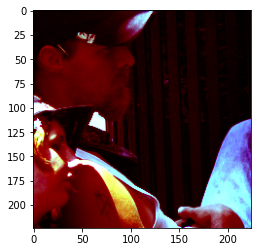

Caption : ['<START>', 'a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'sunglasses', 'is', 'holding', 'a', 'baby', 'in', 'a', '<UNK>', '<STOP>']


True caption:  tensor([[  1,   4,   8,   6,  16, 166,   4, 142,   7,   9, 424,   2]],
       device='cuda:0')


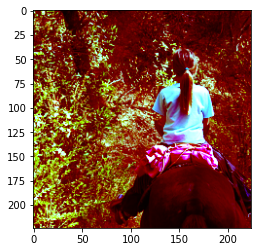

Caption : ['<START>', 'a', 'woman', 'in', 'a', 'black', 'and', 'white', 'shirt', 'is', 'walking', 'on', 'a', 'path', 'with', 'a', '<UNK>', 'in', 'the', 'background']


True caption:  tensor([[  1,   4,  19,  15,  20,   5, 116,  65, 337,   4,  37,  57,   2]],
       device='cuda:0')


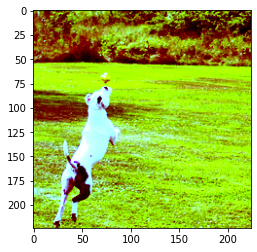

Caption : ['<START>', 'a', 'brown', 'and', 'white', 'dog', 'is', 'running', 'through', 'a', 'field', '<STOP>']


True caption:  tensor([[ 1,  4,  5, 28, 12, 21,  2]], device='cuda:0')


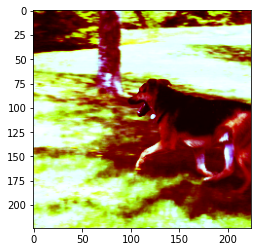

Caption : ['<START>', 'a', 'dog', 'is', 'running', 'through', 'a', 'grassy', 'field', '<STOP>']


True caption:  tensor([[   1,   48,   66,   12,    4,   63,  965,  118,   44,   12,    9,    3,
         1745,    4,  231,    2]], device='cuda:0')


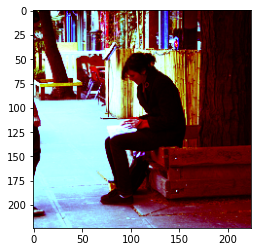

Caption : ['<START>', 'a', 'man', 'in', 'a', 'red', 'jacket', 'and', 'a', 'woman', 'in', 'a', 'black', 'jacket', 'and', 'black', 'pants', 'is', 'sitting', 'on']


True caption:  tensor([[   1,  199,   66,   44,   18,  199, 1758,    2]], device='cuda:0')


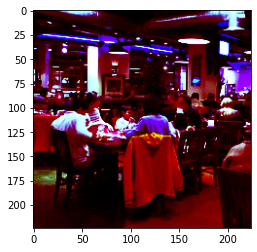

Caption : ['<START>', 'a', 'group', 'of', 'people', 'are', 'sitting', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'building', '<STOP>']


True caption:  tensor([[  1,   4,  59,  78,  11,   4,  55, 712,  79,  26,   9, 638,  71, 101,
           4, 286, 187, 188, 293,  16,  76,  26,   9, 615,   2]],
       device='cuda:0')


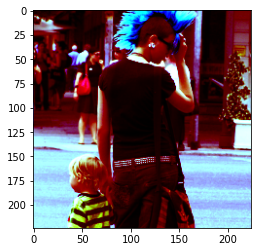

Caption : ['<START>', 'a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'sunglasses', 'is', 'holding', 'a', 'baby', 'in', 'a', '<UNK>', '<STOP>']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc36a6d89e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


True caption:  tensor([[  1,   4,  13,  16, 481,  12,   4, 366,  68,  10,   4, 364,   2]],
       device='cuda:0')


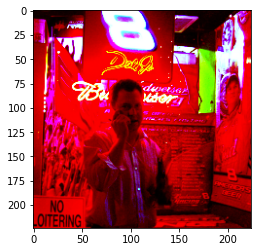

Caption : ['<START>', 'a', 'group', 'of', 'people', 'are', 'sitting', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'building', '<STOP>']


True caption:  tensor([[  1,  69, 256, 118, 101,   4, 907, 695, 207, 153,  12,   4, 252,  45,
          26,   4, 388,   2]], device='cuda:0')


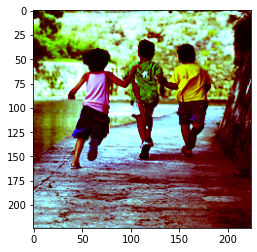

Caption : ['<START>', 'a', 'woman', 'in', 'a', 'red', 'shirt', 'is', 'holding', 'a', 'baby', 'in', 'a', 'pool', '<STOP>']


True caption:  tensor([[   1,    4,   59,  390,    6,   15,    4,   42,   33,   40,   12,    4,
          248, 1829,    2]], device='cuda:0')


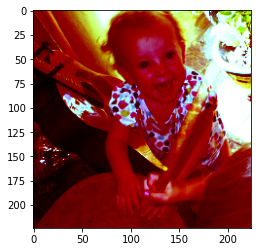

Caption : ['<START>', 'a', 'girl', 'in', 'a', 'pink', 'dress', 'is', 'holding', 'a', 'baby', 'in', 'a', 'pink', 'dress', '<STOP>']


True caption:  tensor([[  1,   4,   6,  75,  12,   4, 342,   2]], device='cuda:0')


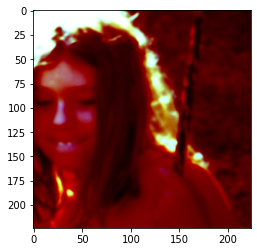

Caption : ['<START>', 'a', 'girl', 'in', 'a', 'pink', 'dress', 'is', 'holding', 'a', 'baby', 'in', 'a', 'pink', 'and', 'white', 'dress', '<STOP>']


True caption:  tensor([[  1,   4,  29,  15,  20,   5, 109,  36,   9,  56,  21,   2]],
       device='cuda:0')


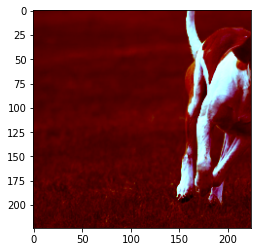

Caption : ['<START>', 'a', 'brown', 'dog', 'is', 'running', 'through', 'a', 'field', '<STOP>']


True caption:  tensor([[  1,   4,  42,   7,   4, 646, 713, 622,   4, 215,  35,   2]],
       device='cuda:0')


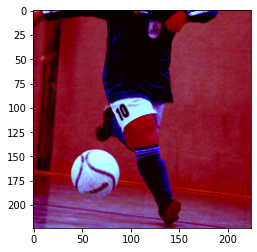

Caption : ['<START>', 'a', 'man', 'in', 'a', 'red', 'uniform', 'is', 'playing', 'with', 'a', 'soccer', 'ball', '<STOP>']


True caption:  tensor([[   1,    4,   78,  115,    7,   37,   15,   19, 1352,   88,    9,  858,
            7,   22,   10,    9,   30,  114,  112,  234,    2]],
       device='cuda:0')


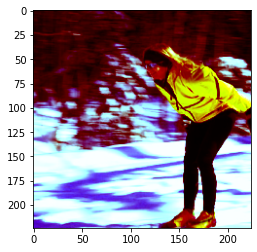

Caption : ['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'riding', 'a', 'bike', 'on', 'a', 'dirt', 'track', '<STOP>']


True caption:  tensor([[   1,   69,   66,   85,   18,    4,  295,  267,   68,   10,    4,   72,
          323,  639,    4, 2677,  565,    2]], device='cuda:0')


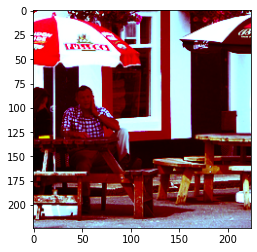

Caption : ['<START>', 'a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'hat', 'is', 'sitting', 'on', 'a', 'bench', 'with', 'a', '<UNK>', 'in']


True caption:  tensor([[   1,  572, 2029,  627,  402,   25,    3,    2]], device='cuda:0')


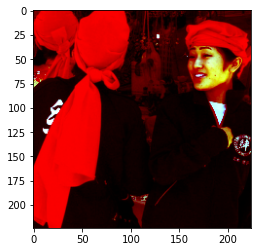

Caption : ['<START>', 'a', 'group', 'of', 'people', 'are', 'sitting', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'building', '<STOP>']


True caption:  tensor([[  1,   4, 244,  11,   4,  19,  81,  16, 106,  39,   4, 882,  12,   4,
          87,   2]], device='cuda:0')


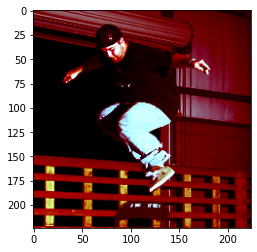

Caption : ['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'riding', 'a', 'bike', 'on', 'a', 'dirt', 'path', '<STOP>']


True caption:  tensor([[  1,   4, 462,   7,   9, 119,  39,   4, 228, 141,   2]],
       device='cuda:0')


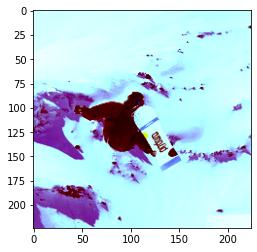

Caption : ['<START>', 'a', 'man', 'in', 'a', 'red', 'jacket', 'is', 'riding', 'a', 'bike', 'on', 'a', 'snowy', 'hill', '<STOP>']


KeyboardInterrupt: ignored

In [35]:
# Test Inference
import math
# define test iterator
testIter = inference(modelInference,testDataloader,vocabulary)

# Execute inference function on your loaded model, test iterator and vocabulary


In [ ]:
# Show the best result you can get. You can try to change parameters, improve training procedures or the model as a bonus.

## **1. Assignment**

Send me by mail your colab link with the code and assignment part filled:

Questions related to Lecture:
* Enumerate different properties of sequences. What type of tasks can involve sequences ? 

Answer：Properties of the sequences: 
1. a sequence is of variable size
2. Sequence's elemtns are often discoverd in real-time
3. A specific order of elements leads to a specific result
4. A single elemtn excluded from the sequence has less meaning
Almost any type of tasks involve sequences , because Our world is continuous，For example, predicting financial markets, athletes' movements, temperature changes, etc.

* Why Recurrent Neural Network have been introduced ? Summarize RNN architecture. How do you define backward propagation through time ? Why is truncated bptt used in practice ?

Answer: Because NNs can fit the target equation automatically and with an optimal trend, but ordinary NNs are not suitable for sequences tasks because NNs have a fixed length of input and sequences have a variable length and have to be able to handle real-time tasks.

The structure of RNN consists of multiple RNN cells, and the RNN cell is the core of RNN. In each cell, the input of the current data and the input of the previous RNN cell are accepted, and then together they decide the output of the current RNN cell, which results in RNN with memory and adapts to any length of data.

Because the RNN accepts data of arbitrary length and the state of each RNN cell has a previous memory, the back propagation takes a long time, By truncated bptt, the computation time of backward propagation will be reduced


* What is the gradient problem ? How to solve it ?
There are two gradient problem.
1. Exploding gradients, gradient clipping can be used to solve this problem
2. Vanishing gradients , new RNN cell architecture can be used to solve this problem

* What is a gated cell unit ? Detail a gated cell unit architecture and explain why they are used in practice.

A gated cell unit is unit that can control the information, it can filter information, it can add, let pass through or remove information.


* Give examples of RNN applications. Explain encoder-decoder architecture for deep sequence modeling.
Image generation, image captioning, visual question answearing.
In the deep sequence modeling, The encoder is used to encode the data input into the model to extract features, and the decoder is used to generate the predicted data by labeling the input data with the features of the input data.

* What is attention ? Why and how is it used with RNN ?

Attention : ability to decide what to focous on, to be selective about what you are looking at or thingking about
Because the attention mechanism allows the model to focus on the more important parts, it usually leads to an increase in model expressiveness, RNN has a memory of past events via their recursive hidden state. When making a decision RNN will attend to some parts of his hidden state only. These states have attended to some specific parts of the data during training.

* What is a transformer, explain their architecture ?
Transformer is a model that get ride of all recurrent aspects and only keep attention mechanisms, tansformers process the whole sequence at once, no recursive processing.
In the input embedding part , the transformer first embed the input data with positional encoding, and then sending the embedding data into multi-head attention by N times, after the attention part, the processed data will send to another multi-head attention part with process output data by masked multi-head attnetion, then by feed forward process, linear layer and softmax operation , we will recieve the output probabilities

* How do you choose your model between RNN, RNN with attention and Transformer ? Is one of these model better than other ?
I will choose transformer , because it is more complex and a lot of paper show transformer have the best performance in terms of evaluation metrics.
Yes , transfomer is better than RNN with attention and RNN.

You need to finish the lab and answer following questions: 

* What are the steps for caption pre-processing ?

We need to build the vocabulary for the caption and numericalize the word,  and add <START> and <STOP> tokens at the beggining and end of each captions.After that we will need to process image to tensor and process the image
* How do you manage data and batch with PyTorch ?

Captions can have different sizes. To ease captions processing, we padd the captions so that all captions have the same lenght inside a same batch of data. for the image data , in order to  fit the Resnet, we randomcrop the image to  224x224 size, which helps our model to achieve better results, and then normalize the images

* Why do we split data into train, validation and test dataset ?

The training set data is used to train the model, which contains most of the data, the validation set data can track the performance of the model during training, and the test set is for the performance of the trained model

* How do you do transfer learning for the encoder part ?

First I declare the model as resnet50, there is a model framework for resnet50 in the pytorch library, then set pretrained=True, this will load the trained weights of the renset50 model on the imagenet dataset for the resnet50 model we defined

* Explain how would you assess performances of the model ?
Firstly, the model is judged by the loss value, the lower the loss value means the better the model is fitted, secondly, the test set data is judged by comparing the caption generated by the model with the real caption
* What is explaining inexact results you see in the lab ?

The training set is not large enough, the objects in the test set do not appear in the training set or the model does not fit, or the model has poor generalization ability

* Cite all the steps you would do to try to improve the results ?

Training for longer periods of time.
Introducing the attention mechanism in the LSTM section.
Replace more advanced models, such as transformer.
Find the optimal hyperparameters by experiment and apply them in the model.

Bonus: Try to get the best result you can. You can try to improve the model, the training procedure or find the best networks initial parameters. If you want to train for a longer number of epochs, you will need to adapt the colab code to use TPU or deploy Pytorch in a local python environment and train in your own GPU.
